# Stereovision

![Suzanne](main.png)

Stereovision is a discipline that deals with the reconstruction of 3D information from images. For the reconstruction of a point, several images of this point are needed. These images must be taken from different points of view. The key step of the reconstruction, which is often problematic, is to identify the images of the point to be reconstructed in each view.

## Epipolar Geometry

Epipolar geometry involves two cameras. The epipolar geometry describes the geometric properties between two views of the same scene and depends only on the intrinsic parameters of the cameras and their relative positions. It provides, in particular, the epipolar constraint, which will be very useful to produce the matches between views.

## The Fondamental Matrix

![Epipolar Geometry - Sanyam Kapoor](epipolar.png)

Let us imagine that we have two images, right and left, of the world space. Let's take a point $\vec{x}$ in the right image space. The point $\vec{X}$ of the world space, of which $\vec{x}$ is the image, can be anywhere on the line passing through $\vec{x}$ and the optical center of the right camera. We will call this line the back-projected ray of $\vec{x}$. Let us note $\vec{x}'$ the image of $\vec{X}$ in the left image space. The locus of $\vec{x}'$ is therefore the image line of the back-projected ray of $\vec{x}$. This line is called the epipolar line and is denoted $\vec{l}'$. The epipolar line passes through the epipole $\vec{e}'$, image of the optical center of the right camera.

In 2D projective geometry, a line with equation $ax+by+c = 0$ is represented by a vector with three components $(a, b, c)^T$ defined to within one factor. Thus, we have the following relationship:

>The point $\vec{x}$ belongs to the line $\vec{l}$ if and only if $x^T\vec{l} = 0$.

Moreover, in 2D projective geometry, the following remarkable relations are valid:

- The intersection of two lines $l$ and $l'$ is given by $x = l \times l'$,
- The line passing through two points $x$ and $x'$ is given by $l = x \times x'$.

Note that the vector product can be written as a product of matrix $x \times y = [x]_\times y$ where

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

To find the equation of the epipolar line in the left image space, we just need to find the coordinates of two points of this line. The first is the image $P'\vec{C}$ of the optical center $\vec{C}$ of the right camera where $P'$ is the projection matrix of the left camera. The second is $P'P^{+}\vec{x}$ where $P^{+}$ is the pseudo inverse of the projection matrix $P$ of the right camera. The epipolar line thus has the equation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ with $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ is called fundamental matrix.

Since the epipolar line $\vec{l}' = F\vec{x}$ is the locus of $\vec{x}'$, $\vec{x}'$ therefore belongs to $\vec{l}'$ which leads to the epipolar constraint :

>**The fundamental matrix is such that for any pair of points corresponding $\vec{x} \leftrightarrow \vec{x}'$ in the two images, we have $\vec{x}'^{T}F\vec{x} = 0$.**

## Computation of the fundamental matrix

The fundamental matrix $F$ has seven degrees of freedom. It has nine components but these are defined to within one scale factor, which removes one degree of freedom. Moreover, the matrix $F$ is a singular matrix ($det(F) = 0$) which gives us seven degrees of freedom. So we need at least seven correspondences to compute $F$. The equation $x'^{T}_iFx_i = 0$ and the seven correspondences allow us to write a system of equations of the form $Af = 0$, where $f$ is the vector which contains the components of the matrix $F$. Let us assume that $A$ is a 7×9 matrix of rank 7. The general solution of $Af = 0$ can be written $\alpha f_1 + (1-\alpha) f_2$ where $f_1$ and $f_2$ are two particular independent solutions of $Af = 0$. We then use the singularity constraint $det(\alpha F_1 + (1 - \alpha)F_2) = 0$ to determine $\alpha$. Since the singularity constraint gives rise to a third degree equation, we may have one or three solutions for $F$.

## OpenCV

In practice you will use the OpenCV library. In python, you have access to its functions through the `cv2` module.

You can find help with the calibration and reconstruction functions on the site https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Goal

In the zip of the statement you will find two sequences of images taken by two cameras during the scanning of an object by a laser plane.

![Laser](scanRight/scan0010.png)

You will also find shots of a checkerboard in different positions that will help you calibrate your cameras.

![Damier](chessboards/c2Right.png)

The goal is to reconstruct the scanned object in 3D.

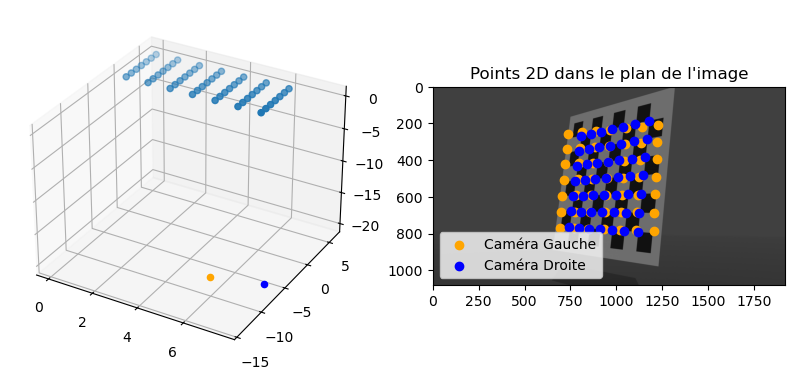

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import glob

# criteria : Définit les critères d'arrêt utilisés par la fonction de raffinement cv.cornerSubPix.
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001) #pour ameliorer la precision de la position des coins

# objp : Initialise une matrice pour contenir les coordonnées 3D de points sur le damier (coins).
objp = np.zeros((7*7, 3), np.float32) #mattrice (49,3) pour stocker valeurs des points du damier en 3d
objp[:, :2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2) #mattrice (49,2) pour stocker valeurs des points du damier en 2d où on prend que les valeurs en x et en y

# objpoints et imgpoints : Listes vides pour stocker respectivement 
# les coordonnées 3D des points réels et les coordonnées 2D des points dans l'image.
objpoints = [] #3d
imgpoints = [] #2d

# Boucle à travers les images du damier. Lit chaque image, convertit en niveaux de gris (gray).
for fname in glob.glob('chessboards/c2*.png'):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Trouver les coins du damier
    ret, corners = cv.findChessboardCorners(gray, (7, 7), None) #Utilise la fonction cv.findChessboardCorners pour détecter les coins du damier. Si les coins sont trouvés (ret est True) 
    if ret:
        # Raffiner les coins pour une meilleure précision
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria) # utilise ensuite cv.cornerSubPix pour raffiner les positions des coins.
        objpoints.append(objp) 
        imgpoints.append(corners2)
        #cv2.imshow('Chessboard corners', img)

# Applique la calibration de la caméra en utilisant la fonction cv.calibrateCamera. ret true or false
#Renvoie la matrice de la caméra (mtx), les coefficients de distorsion (dist) qui modélisent les défauts optiques de la lentille.,
# les vecteurs de rotation (rvecs) -> Pint, et les vecteurs de translation Une liste de vecteurs de translation pour chaque image, 
#représentant la position de la caméra par rapport au système de coordonnées du monde 
#(tvecs) -> T
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Convertit les vecteurs de rotation en matrices de rotation à l'aide de la fonction cv.Rodrigues. -> R
rmatRight = cv.Rodrigues(rvecs[0])[0]
rmatLeft = cv.Rodrigues(rvecs[1])[0]

# Crée les matrices de rotation et de translation (matrices extrinsèques) pour chaque caméra.
rotMatRight = np.concatenate((rmatRight, tvecs[0]), axis=1) #il faut les combiner (rot et translation) pour connaitre à la fois la position de la cam et son orientation de viser
rotMatLeft = np.concatenate((rmatLeft, tvecs[1]), axis=1)

# Calcule les matrices de caméra en multipliant la matrice intrinsèque (mtx) par la matrice extrinsèque.
camLeft = mtx @ rotMatLeft
camRight = mtx @ rotMatRight

# Calcule le centre de projection de chaque caméra dans le monde en inversant la matrice extrinsèque
# et en multipliant par les coordonnées homogènes [0, 0, 0, 1].
camWorldCenterLeft = np.linalg.inv(np.concatenate((rotMatLeft, [[0, 0, 0, 1]]), axis=0)) @ np.transpose([[0, 0, 0, 1]])
camWorldCenterRight = np.linalg.inv(np.concatenate((rotMatRight, [[0, 0, 0, 1]]), axis=0)) @ np.transpose([[0, 0, 0, 1]])

def plotDotWorld():
    fig = plt.figure(figsize=(10, 5))
    
    # Affichage des points 3D de l'objet
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter3D(objp[:, 0], objp[:, 1], objp[:, 2])
    ax1.scatter(camWorldCenterLeft[0], camWorldCenterLeft[1], camWorldCenterLeft[2], c='orange', marker='o')
    ax1.scatter(camWorldCenterRight[0], camWorldCenterRight[1], camWorldCenterRight[2], c='b', marker='o')
    
    # Affichage des points 2D dans le plan de l'image
    ax2 = fig.add_subplot(122)
    ax2.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))  # Affichage de l'image
    ax2.scatter(imgpoints[0][:, 0, 0], imgpoints[0][:, 0, 1], c='orange', marker='o', label='Caméra Gauche')
    ax2.scatter(imgpoints[1][:, 0, 0], imgpoints[1][:, 0, 1], c='b', marker='o', label='Caméra Droite')
    ax2.set_title("Points 2D dans le plan de l'image")
    ax2.legend()
    
    plt.show()

plotDotWorld()

mask
4.10.0


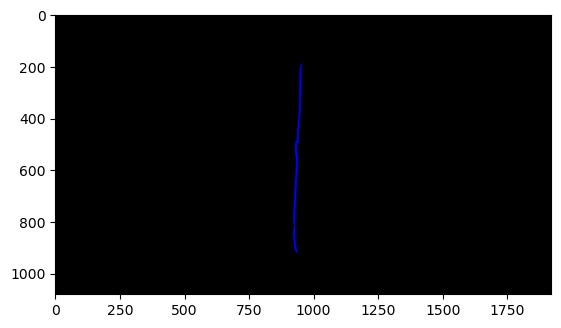

In [4]:
#sert juste a afficher le résultat de getImgLine(fname) une fois    
img = cv.imread("scanRight/scan0012.png")                                      #stocke l'image dans une variable
ret, mask = cv.threshold(img,127,255,cv.THRESH_TOZERO)                         #on enleve tout ce qui a une intensité inférieur à 127 et on garde
#que ce qui a une intensité entre 127 et 255 (valeur max) afin de filtrer image pour garder que une ligne
print("mask")
plt.imshow(mask)   

#on a reussi a prendre une ligne, si on prend toutes les lignes de tout les scans on pourra reconstruire

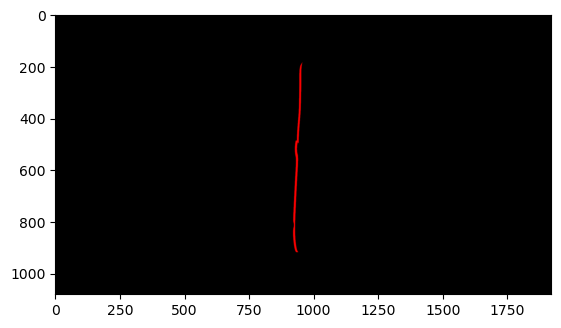

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def filter_red_color(image):
    # Convertir l'image en espace de couleur HSV car plus facile pour analyser pour cv l'image
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    # Plage de teintes pour le rouge (0-30 et 150-180) valeur du rouge
    #de 100 à 255 de saturation pour eviter que ce soit trop desaturé, et de 100 à 255 de value pour eviter les rouges trop sombre
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([30, 255, 255])
    lower_red2 = np.array([150, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    # Créer un masque pour les pixels rouges
    mask1 = cv.inRange(hsv_image, lower_red, upper_red) #creer masque binaire pour avoir en blanc les pixel qui correspond au filtre et en noir ceux qui correspondent pas
    mask2 = cv.inRange(hsv_image, lower_red2, upper_red2)

    # Combinez les deux masques pour avoir toutes les teintes de rouge des deux masques en blanc sur une image et le reste en noir
    mask = cv.bitwise_or(mask1, mask2)

    # Appliquer le masque à l'image d'origine pour avoir que la ligne 
    result = cv.bitwise_and(image, image, mask=mask)

    return result

# Charger l'image
img = cv.imread("scanRight/scan0012.png")

# Appliquer le filtrage des pixels rouges
filtered_image = filter_red_color(img)

# Afficher l'image filtrée
plt.imshow(cv.cvtColor(filtered_image, cv.COLOR_BGR2RGB))
plt.show()


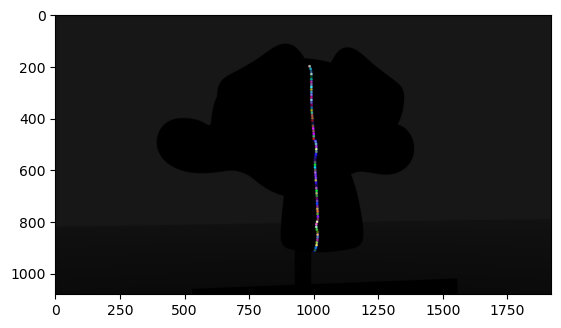

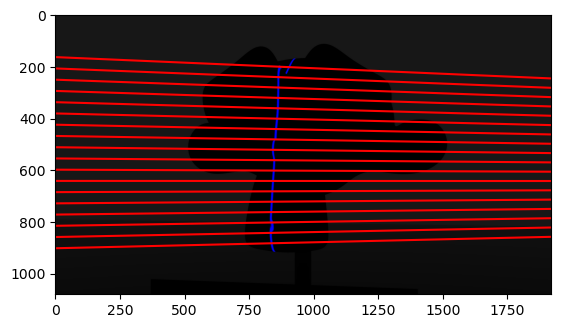

In [7]:
# Cette fonction prend un vecteur v en entrée et renvoie sa matrice de croix associée.
# La matrice de croix est utilisée dans la triangulation stéréo.
def crossMat(v):
    # Soit                          V = [[xxx][yyyy][zzzz]]
    v = v[:,0]    # qui donne donc  V = [xxx yyyy zzzz]               
            # Et on  retourne   ([[0000  -zzzz    yyyy]
            #                   [zzzz   0000   -xxxx]
            #                   [-yyyy  xxxx    0000]])

    return np.array([[0,-v[2],v[1]] , [v[2],0,-v[0]] , [-v[1],v[0],0]]) #cela permet de calculer le produit vectoriel comme une simple multiplication de matrice

# Cette fonction calcule la matrice fondamentale en utilisant les matrices de projection des caméras gauche et droite, 
# ainsi que le centre de projection de la caméra droite dans le système de coordonnées du monde.
def matFondamental(camLeft,centerRight,camRight): #objectif calculer la matrice fondamental utilisé pour l'appariement des points elle relie les coordoné d'un point d'une image avec celles d'une autre image
        # pseudo inverse de la matrice camRight, qu'on multiplie par camLeft (= MatriceIntrinsèque @ MatriceRota)
        # qu'on multiplie ensuite par (camLeft @centerRight) qui représente la matrice asymétrique pour ce vecteur qui capture la géometrie du point
        # Et on fait finalement le cross product (produit vectoriel) de la matrice colonne resultat
        return np.array(crossMat(camLeft @ centerRight) @ camLeft @ np.linalg.pinv(camRight)) #matrice fondamental etabli relation entre les points correspondant de l'image gauche et droite


#Produit matriciel : camLeft @ centerRight représente la projection du centre de la caméra droite sur l'image gauche.
#Matrice de croix : Le produit crossMat(camLeft @ centerRight) produit la matrice antisymétrique pour ce vecteur, qui capture la géométrie du point.
#Pseudo-inverse de camRight : np.linalg.pinv(camRight) est la pseudo-inverse de la matrice de projection de la caméra droite, nécessaire pour obtenir une relation linéaire entre les images stéréo.
#Le produit final produit la matrice fondamentale, qui est utilisée pour établir la relation entre les points correspondants dans les images gauche et droite.

# Cette fonction prend en entrée le nom d'un fichier image, extrait le canal rouge et
# applique un seuillage pour créer un masque qui ne conserve que la partie rouge de l'image.
def getImgLine(fname):              
    img = cv.imread(fname)                                      #stocke l'image dans une variable
    red = img[:,:,2]                                            #concrètement ça évite une erreur dans epiLine qui svt attend des images binaire et non rgb
    ret, mask = cv.threshold(red,127,255,cv.THRESH_TOZERO)      #vire tout ce qui n'est pas la ligne rouge
    return mask
    
# Cette fonction prend en entrée un chemin d'accès et cherche les épilignes (lignes épipolaires)
# pour chaque image dans ce chemin en utilisant la matrice fondamentale
# Chaque point dans l'image gauche est projeté sur un plan épipolaire dans l'image droite, et vice versa.
# Les lignes épipolaires sont ainsi créées en intersectant le plan image avec les plans image de l'autre caméra
# Ces lignes sont utiles dans la correspondance stéréo, où l'on cherche à associer des points dans une image à leurs correspondants dans l'autre image.
def findEpilines(path):
    epilines = []
    # (la boucle for traverse les images)
    for l in range(26):                                 #On a 25 images, donc pour chaque image
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
            
        ImgLine = getImgLine(strp)                      #On transforme l'image en un fond avec simplement la ligne de gardée
        pointsLeft = [[],[],[]] #cree un vecteur de coordonées de point de l'image gauche coordonées X, Y et representation en coordonées homogènes

        for index, line in enumerate(ImgLine):              # on prends l'index de la ligne et la ligne correspondante
            for pixel in line:                              # pour chaque pixel de la ligne
                if pixel != 0:                              # si le pixel n'est pas nul (vu qu'on a viré tout le reste précédemment)
                    pixel = 1                               # sa valeur vaut 1
            try:
                pointsLeft[0].append(np.average(range(1920), weights = line))   # avg = sum(a * weights) / sum(weights)
                #on fait la moyenne de tout les points non nul donc en rouge pour trouver sa valeur en x
                pointsLeft[1].append(index)                                     # index de la ligne
                pointsLeft[2].append(1)                                         # coord homogènes
                #La dernière coordonnée est fixée à 1 pour conserver la forme homogène des points, nécessaire pour certains calculs matriciels
            except:
                pass
            
        epilinesRight = Fondamental @ pointsLeft            # la matrice fondamentale est utilisée pour projeter les points de l'image gauche sur l'image droite.
        epilines.append([pointsLeft, epilinesRight])        # on stock pour cette image les pointsLeft et les epilinesRight ce qui crée les lignes épipolaires (je pense)
    return epilines

#La matrice fondamentale est une matrice qui encode la relation géométrique entre les points correspondants dans les deux images. Si un point 
#𝑥
#x dans l'image gauche est connu, la matrice fondamentale permet de calculer la ligne épipolaire dans l'image droite, sur laquelle se trouve son correspondant.
#ligne épipolaire est une ligne qui relie les points de l'image gauche par exemple et le point de l'image droite se trouvera forcement quelque part sur la ligne épipolaire

Fondamental = matFondamental(camRight,camWorldCenterLeft,camLeft)
# epl = [ [ [Red_x_avg], [Y_avg], [1] ], [EpilineRight(i)] ] ]
# La fonction findEpilines est appelée pour obtenir les épilignes pour les images dans le dossier 'scanLeft/'
epl = findEpilines('scanLeft/')
#La variable epl contient les points moyens détectés dans l'image gauche et les lignes épipolaires correspondantes dans l'image droite.

# Cette fonction prend le nom d'une image et les points de gauche (x moyens) pour cette image et les dessine sur l'image.
def drawAvgPoint(fname,EplLeft):                                                    # Cette fonction affiche les points de la ligne laser, input le nom de l'img et les pointsLeft de l'img
    img = cv.imread(fname)                                                          # 
    i = 0
    while i< len(EplLeft[0]):                                                       # Tant qu'il y a des "avg" qui n'ont pas été couverts
        color = tuple(np.random.randint(0,255,3).tolist())                          #
        img = cv.circle(img,(int(EplLeft[0][i]),int(EplLeft[1][i])),5,color,-1)     #
        i += 10                                                                     #
    plt.imshow(img)                                                                 # On affiche l'image modifiée
    plt.show()      

# Cette fonction calcule y pour une ligne donnée (représentée par ses coefficients) et une valeur de 
# x. Elle est utilisée pour dessiner les épilignes.
def lineY(coef, x): # pour trouver y en fonction de x et de abc car ax+by+c=0
    a, b, c = coef
    return -(c + a * x) / b


def drawEpl(fname,EplRight):
    img = cv.imread(fname)
    coef , length = EplRight.shape #Les lignes épipolaires sont représentées par des coefficients de la forme a,b et c pour chaque épiligne
    for i in range(0,length,40):
        #print(EplRight[:,i])
        plt.plot([0,1919],[lineY(EplRight[:,i],0),lineY(EplRight[:,i],1919)],'r')
        
    plt.imshow(img)
    plt.show()

drawAvgPoint('scanLeft/0013.png',epl[13][0])
drawEpl('scanRight/scan0013.png',epl[13][1])
#epl[13][0] epl left , epl[13][1] epl right

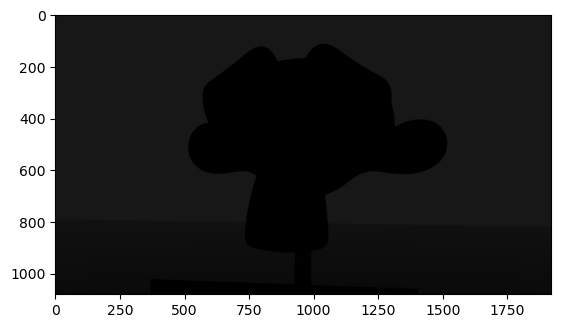

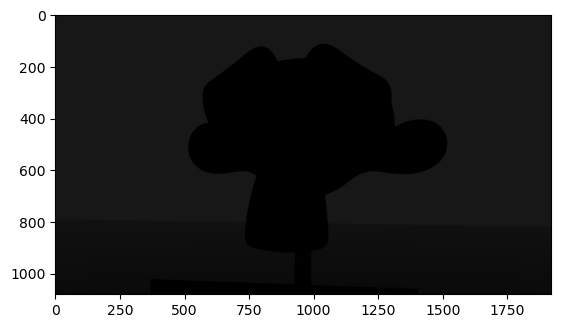

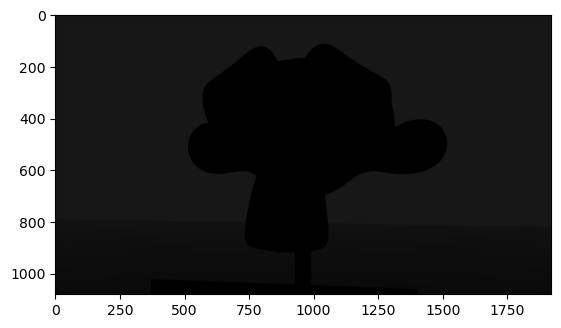

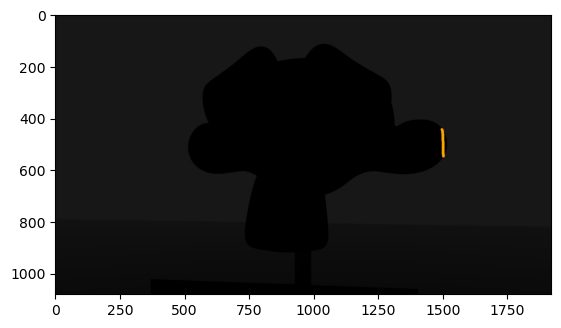

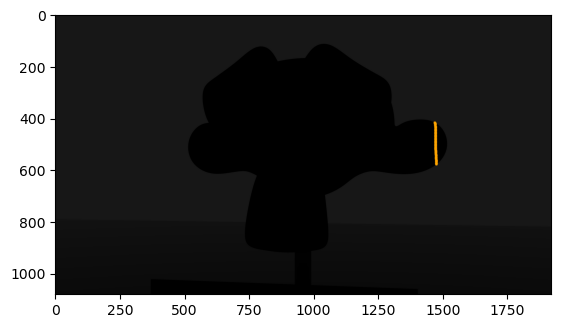

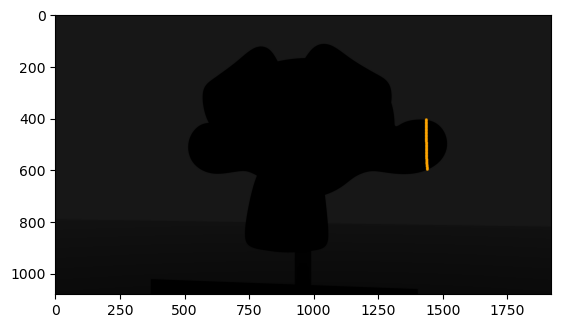

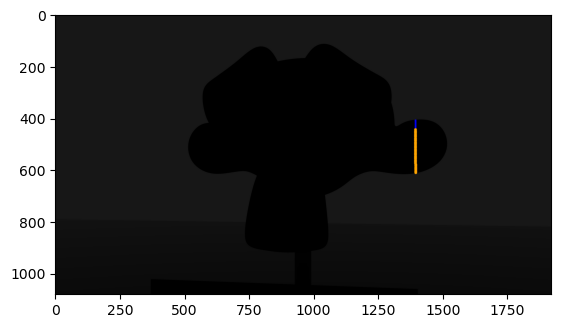

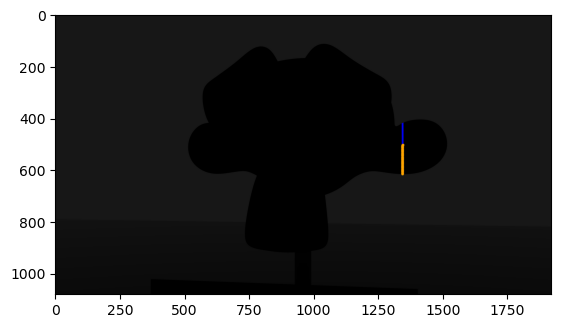

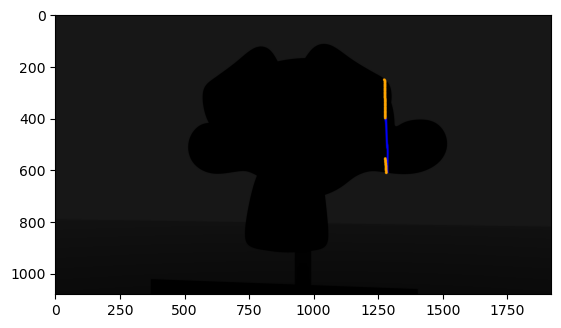

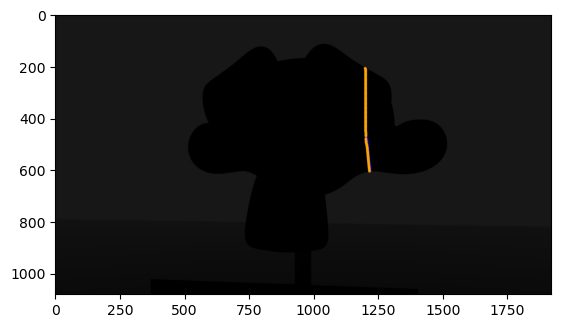

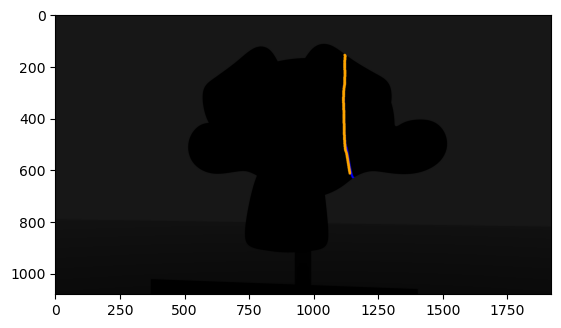

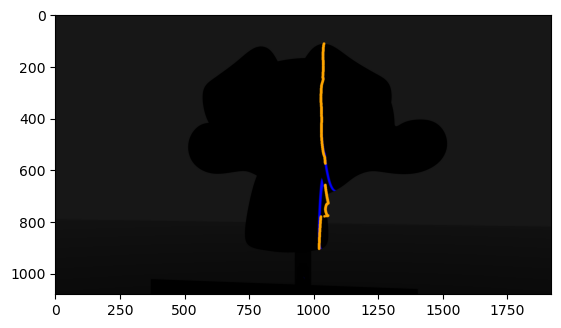

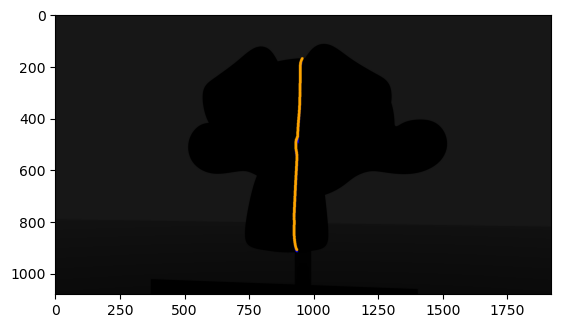

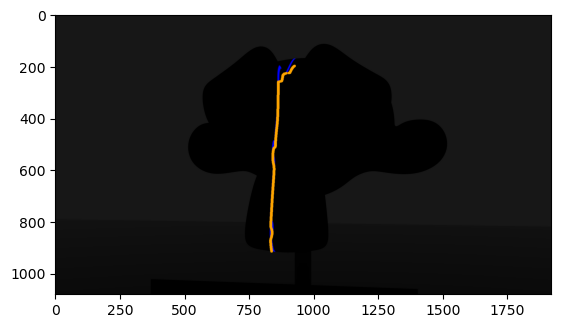

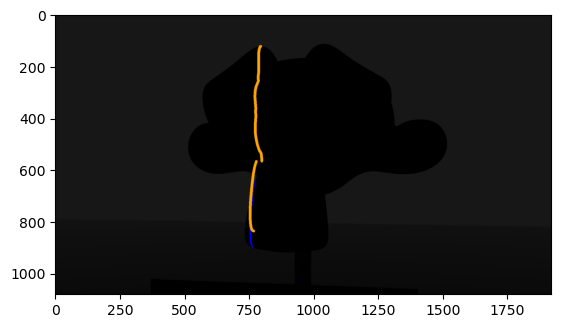

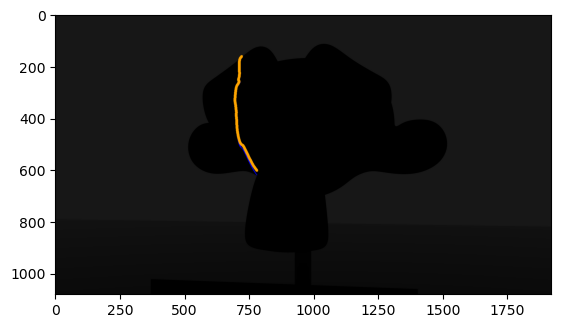

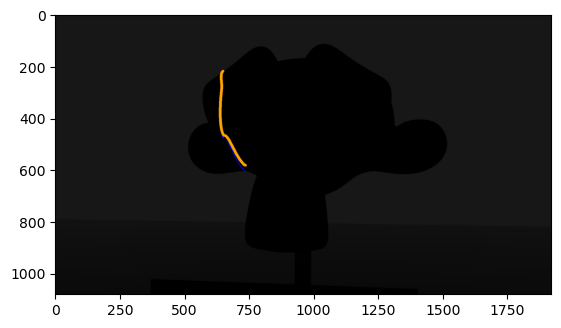

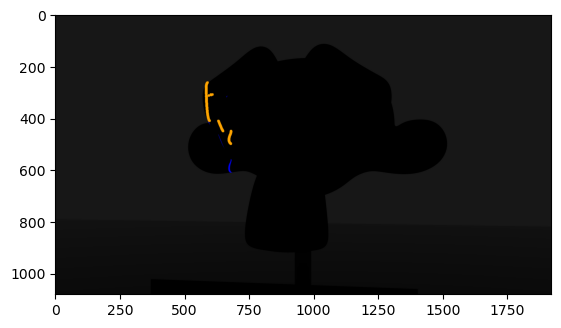

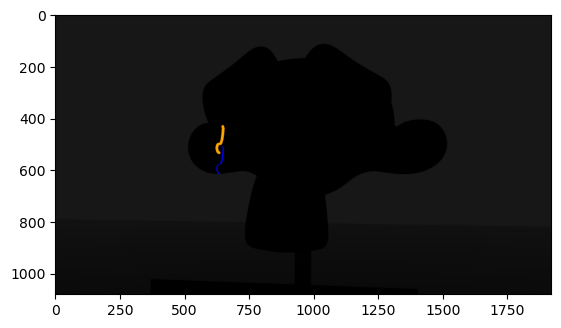

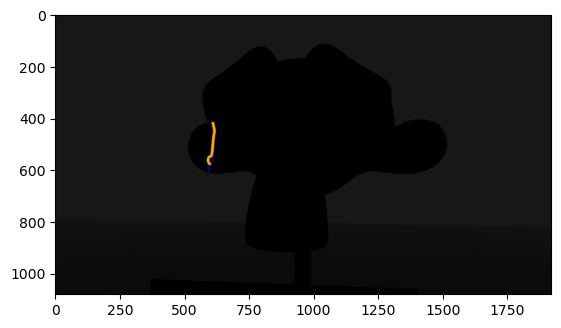

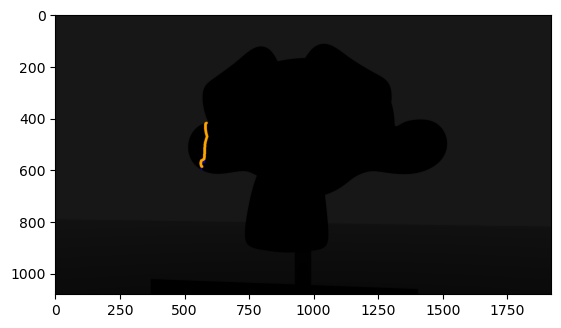

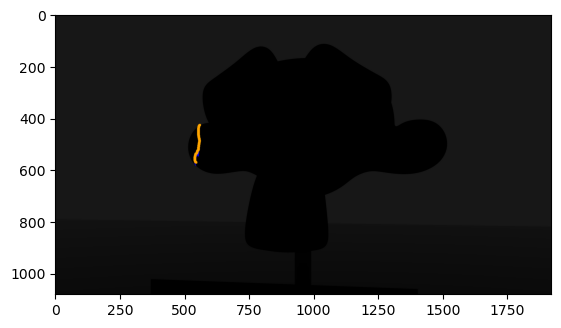

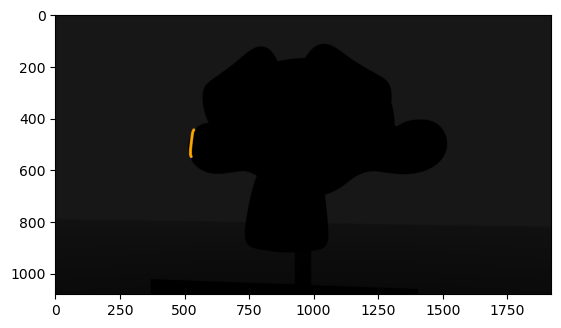

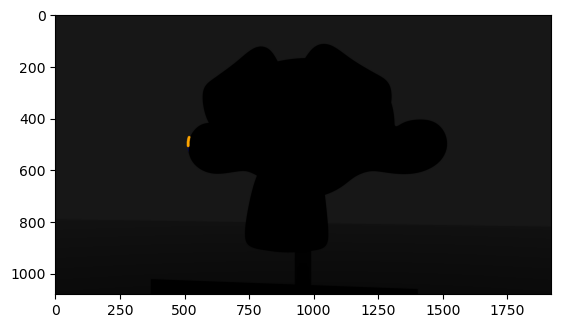

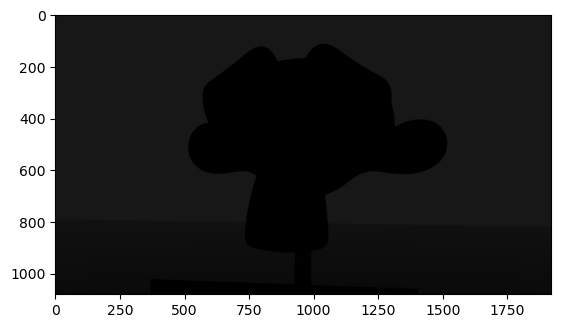

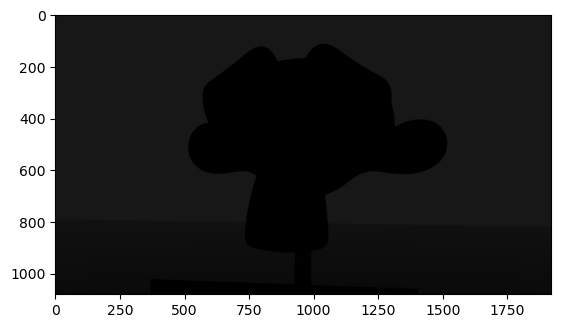

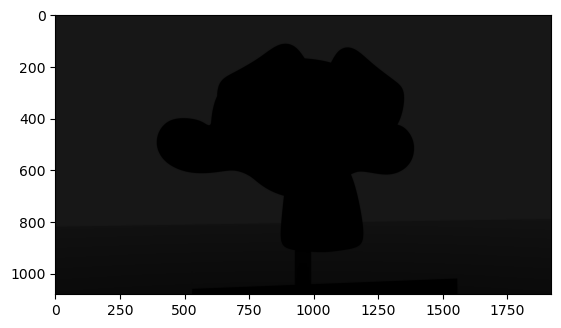

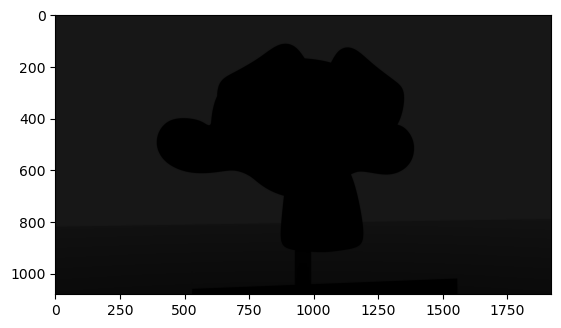

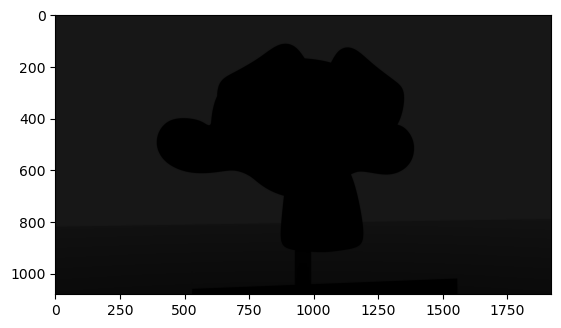

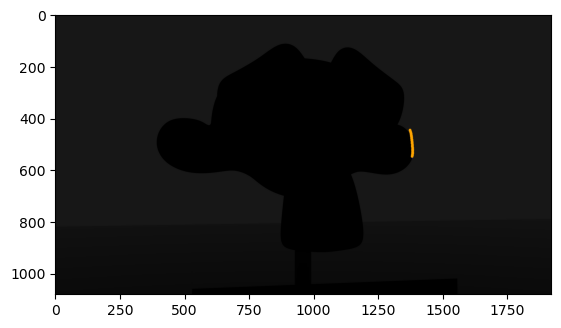

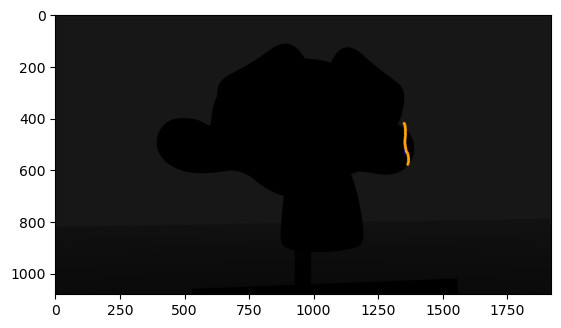

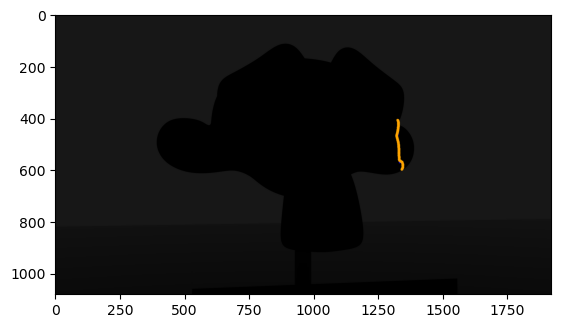

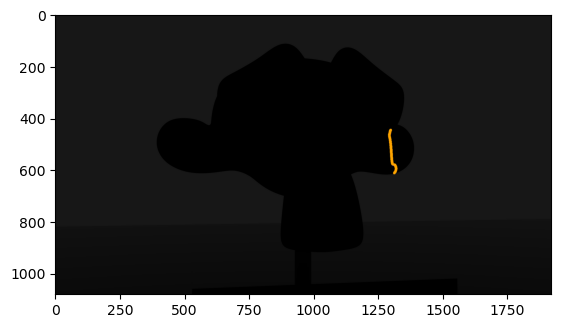

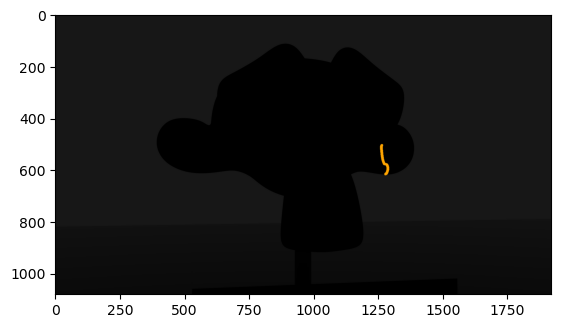

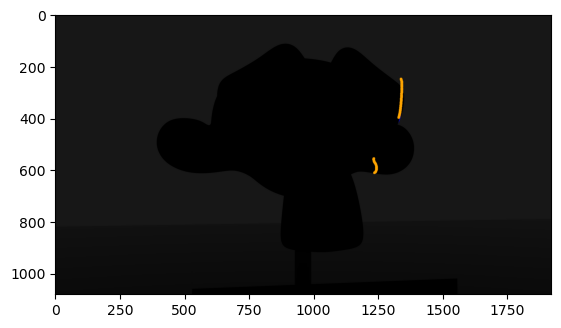

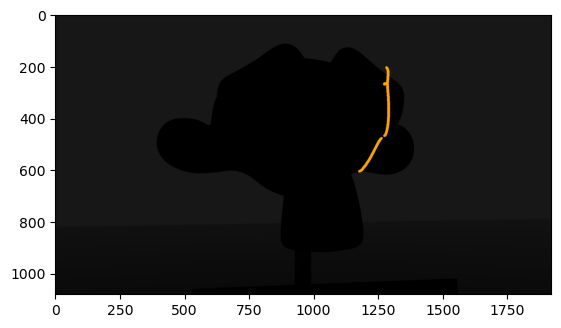

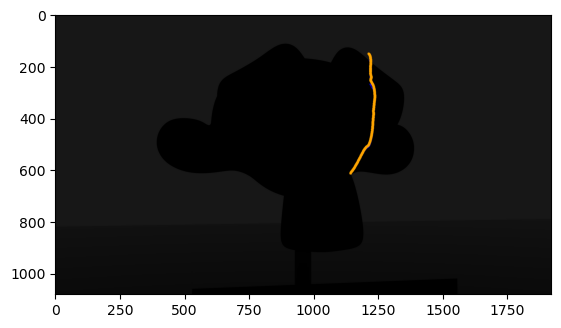

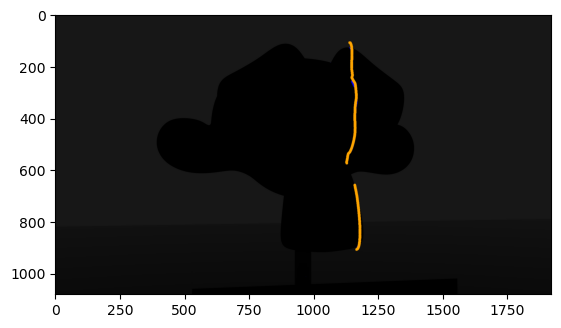

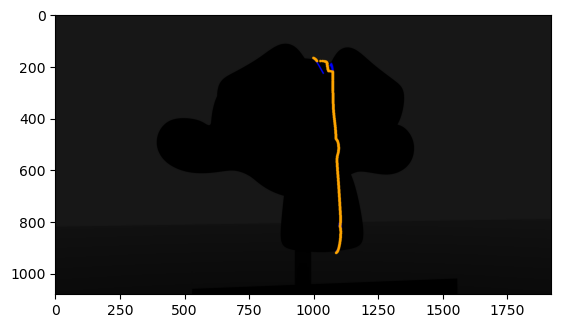

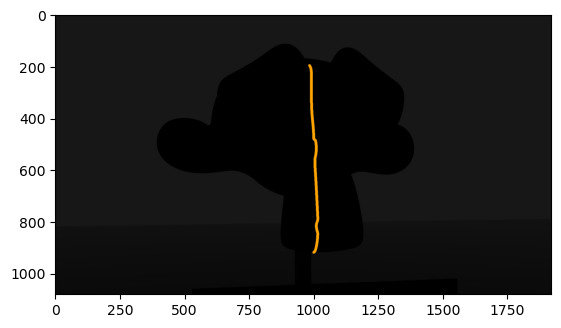

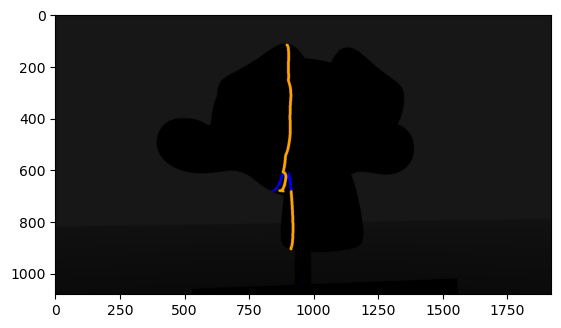

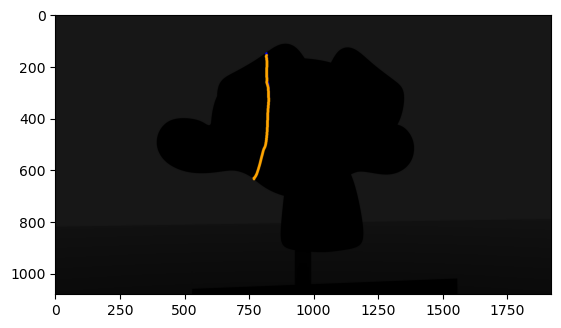

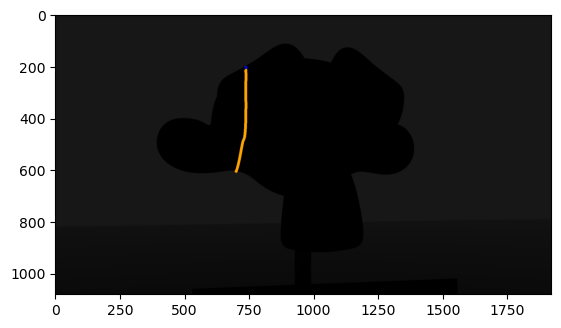

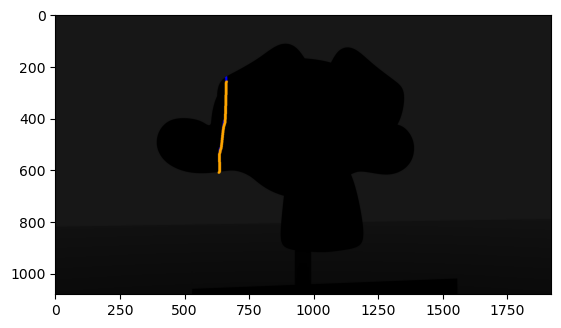

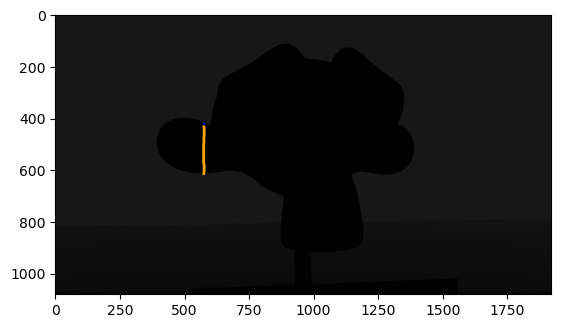

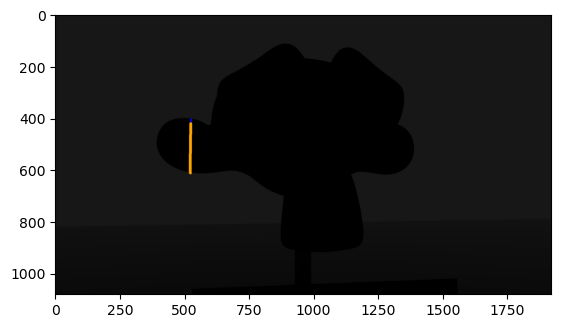

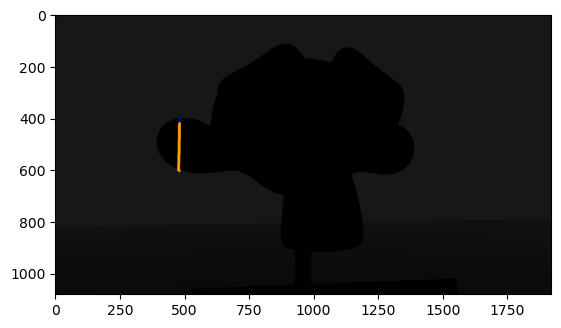

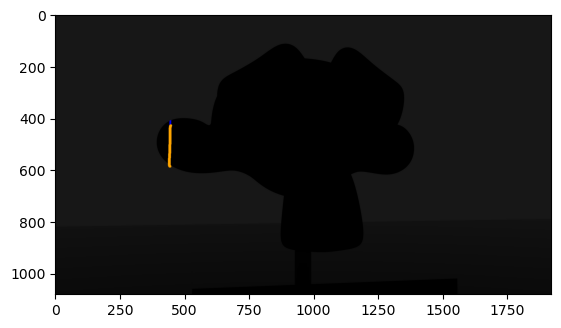

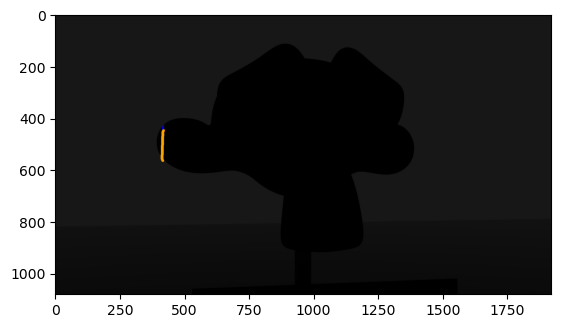

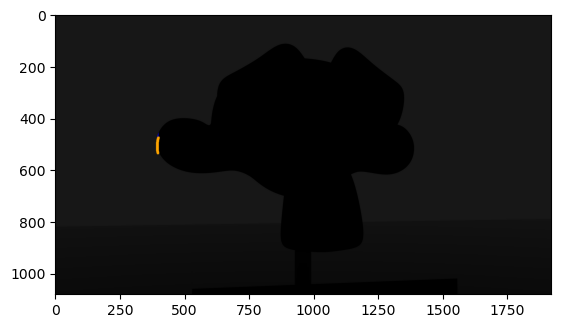

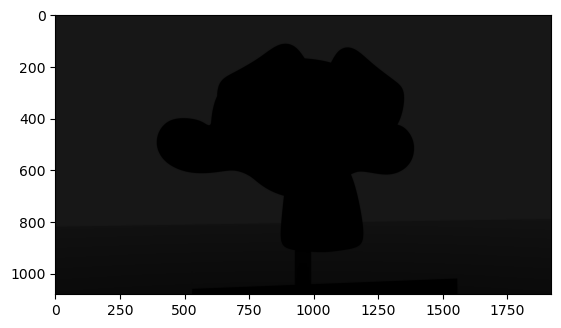

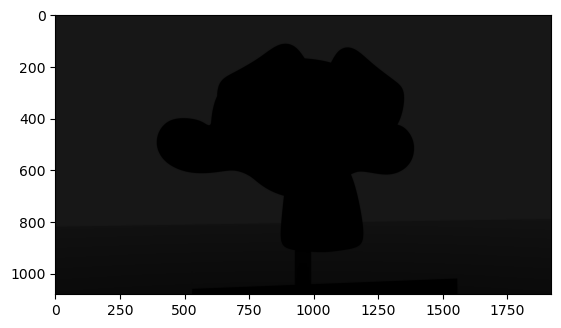

In [6]:
# Elle utilise la fonction getImgLine(fname) pour obtenir le canal rouge de l'image, puis crée une liste redPoints pour stocker les points rouges.
def getReddAvg(fname):
    red = getImgLine(fname)
    redPoints = [[],[],[]]
# Elle utilise la fonction getImgLine(fname) pour obtenir le canal rouge de l'image, puis crée une liste redPoints pour stocker les points rouges.
    for i, line in enumerate(red):
        for pixel in line:
            if pixel != 0:
                pixel = 1
        try:
            redPoints[0].append(np.average(range(1920), weights = line))
            redPoints[1].append(i)
            redPoints[2].append(1)
        except:
            pass
#         La fonction renvoie redPoints, qui contient les coordonnées des points rouges moyens.
    return redPoints #vraiment la meme chose que avant 
    #La fonction retourne redPoints, contenant les coordonnées moyennes des pixels rouges pour l'image.

# Elle parcourt 26 images dans le dossier spécifié par path. Pour chaque image,
# elle utilise getReddAvg pour obtenir les points rouges moyens (redPoints).
# Ensuite, elle parcourt chaque point de l'épiline droite correspondante (EplRight[l][1]), 
# utilise lineY pour calculer l'ordonnée correspondante à la position x du point rouge, et stocke ces points dans pointsRight.
# Elle dessine également des cercles colorés sur l'image pour chaque point rouge détecté
# Enfin, elle affiche l'image modifiée avec les cercles.
# La fonction renvoie la liste points contenant les coordonnées des points droits correspondants pour les 26 images.
def eplRedPoints(path,EplRight):
    points = []
    for l in range(26):
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
            
        redPoints = getReddAvg(strp)
        scan = cv.imread(strp)

        pointsRight = [[],[],[]]
        eplImg = EplRight[l][1]
        # print(strp)
        for i in range(len(eplImg[0])):
            try : 
                x = int(redPoints[0][i])
                y = int(lineY(eplImg[:,i],x))
                pointsRight[0].append(x)
                pointsRight[1].append(y)
                pointsRight[2].append(1)
                
                # color = tuple(np.random.randint(0,255,3).tolist())
                color = (255, 165, 0)
                scan = cv.circle(scan,(x,y),5,color,-1)
            except:
                pass
        points.append(pointsRight)
        plt.imshow(scan)
        plt.show()
    return points

#tout la meme mais en rouge 
pointsRight = eplRedPoints('scanRight/scan',epl)
pointsLeft = eplRedPoints('scanLeft/',epl)

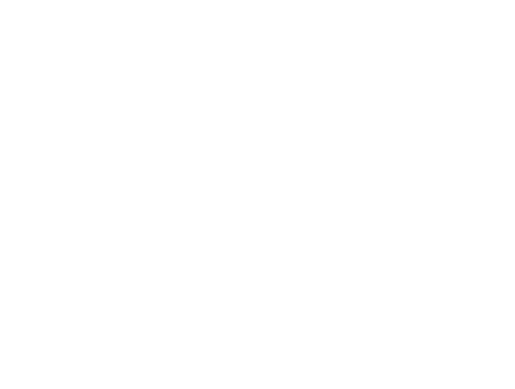

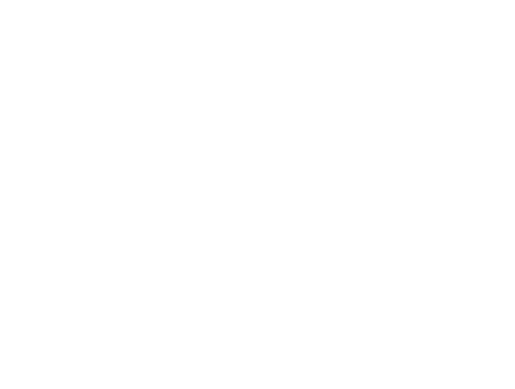

In [24]:
from mathutils import geometry as pygeo
from mathutils import Vector
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def arrayToVector(p):
    return Vector((p[0],p[1],p[2]))

# Cette fonction prend les points des deux caméras (pointsLeft et pointsRight) 
# et effectue plusieurs calculs géométriques pour trouver l'intersection des lignes de vue.
def getIntersection(pointsLeft,pointsRight):
    
    pL = np.array(pointsLeft)
    pR = np.array(pointsRight)
    #pointsLeft et pointsRight représentent les coordonnées homogènes des points observés dans les images gauche et droite respectivement. Ils sont convertis en tableaux NumPy pour faciliter les calculs matriciels.
    
    camCenterRight = np.transpose(camWorldCenterRight)[0]
    camCenterLeft = np.transpose(camWorldCenterLeft)[0]
    #camWorldCenterRight et camWorldCenterLeft sont les coordonnées des centres des caméras dans le monde 3D. Ces centres sont essentiels car les lignes de vue partent de ces points pour passer par les points projetés sur les images.
    
    # calcul du point sur l'object en applicant la pseudo-inverse de la camera sur le point trouvé plus-haut
    #Cela permet de "ramener" les points projetés sur les images dans l'espace 3D par rapport à chaque caméra.
    
    leftObject = (np.linalg.pinv(camLeft) @ pL)
    rightObject = (np.linalg.pinv(camRight) @ pR) 
    
    # conversion des np.array en mathutils.Vector pour l'utilisation de la methode d'intersection
    
    leftEndVec = arrayToVector(leftObject)
    rightEndVec = arrayToVector(rightObject)
    
    leftStartVec = arrayToVector(camCenterLeft)
    rightStartVec = arrayToVector(camCenterRight)

    #leftStartVec et rightStartVec sont les points de départ des lignes de vue, c'est-à-dire les centres des caméras. leftEndVec et rightEndVec sont les points où ces lignes touchent l'objet.
    
    # affichage des lignes reliant centre à point objet
    
    '''
    draw3DLine(camCenterLeft,leftObject)
    draw3DLine(camCenterRight,rightObject)
    plt.show()
    '''
    
    # utilisation de mathutils.geometry.intersect_line_line pour trouver l'intersection des lingnes passant par les 2 
    # points. 
    return pygeo.intersect_line_line(leftStartVec,leftEndVec,rightStartVec,rightEndVec)
#Cette ligne utilise la fonction intersect_line_line de mathutils.geometry pour trouver l'intersection entre deux lignes. Les lignes sont définies par leurs points de départ (centres des caméras) et leurs points finaux (points projetés sur l'objet dans l'espace 3D).
#Si les deux lignes se croisent, cette fonction renvoie le point d'intersection. Si elles ne se croisent pas exactement (ce qui est souvent le cas en raison de petites erreurs), elle renverra une estimation du point d'intersection le plus proche


# Cette fonction prend les coordonnées de début et de fin d'une ligne en 3D et trace cette ligne en utilisant Matplotlib.
def draw3DLine(start, end):
    figure = plt.figure()
    ax = figure.add_subplot(111, projection='3d')
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    x_start, y_start, z_start = start
    x_end, y_end, z_end = end

    print("start = ({},{},{})".format(x_start, y_start, z_start))
    print("end = ({},{},{})\n".format(x_end, y_end, z_end))

    ax.scatter(x_start, y_start, z_start, c='r', marker='o')
    ax.plot([x_start, x_end], [y_start, y_end], [z_start, z_end])

    plt.show()


# Cette fonction effectue la triangulation en appelant getIntersection
# pour chaque paire de points de caméra gauche et droite et retourne un tableau de points résultants.
def getObjectPoint():
    point = [[],[],[]] #x, y et Z
    for l in range(26): #Pour chaque image l, les points correspondants de la caméra gauche et de la caméra droite sont extraits
        pointsLeft = np.array(epl[l][0])
        
        pointRight = np.array(pointsRight[l])
        for i in range(len(pointsLeft[0])):
            try:
                
                # calcul du point d'intersection sur l'objet -> on obtient une liste de vector
                intersection = getIntersection(pointsLeft[:,i],pointRight[:,i])
                # print(intersection)
                for inter in intersection:
                    inter *= 1000 #convertir unité
                    x,y,z = inter
                    point[0].append(x)
                    point[1].append(y)
                    point[2].append(z) #chaque point est extrait et mis dans une liste qui correspond
            except:
                pass
    return np.array(point)
    
# Cette fonction utilise Matplotlib pour afficher les points en 3D.
def drawPointObject(point):
    figure = plt.figure()
    ax = Axes3D(figure)
    
    ax.scatter3D(point[0,:], point[1,:], point[2,:], s=100, c='black', marker='x')     
    ax.view_init(-90, -70)

    # Définir la plage des axes pour mieux visualiser les points
    ax.set_xlim([min(point[0, :]), max(point[0, :])])
    ax.set_ylim([min(point[1, :]), max(point[1, :])])
    ax.set_zlim([min(point[2, :]), max(point[2, :])])

    plt.axis('off')
    plt.show()
    
# Cette fonction utilise Matplotlib pour afficher la surface en 3D à l'aide de la méthode plot_trisurf.
def drawSurfaceObject(point):
    figure = plt.figure()
    ax = Axes3D(figure)
    ax.plot_trisurf(point[0,:],point[1,:],point[2,:])     

    ax.view_init(-95,-50)
    plt.axis('off')
    plt.show()
    
# Cette fonction prend les points triangules et les enregistre dans un fichier JSON nommé point.txt
def pointToJson(point):
    data = {'x':point[0,:].tolist(),'y':point[1,:].tolist(),'z':point[2,:].tolist()}
    with open('point.txt','+w') as file:
        json.dump(data,file)

# Appelez la fonction getObjectPoint pour obtenir les données de point
point = getObjectPoint()

# Appelez la fonction drawSurfaceObject pour afficher la surface
drawSurfaceObject(point)

# Appelez la fonction drawPointObject pour afficher les points
drawPointObject(point)

# Appelez la fonction pointToJson pour sauvegarder les points dans un fichier JSON
pointToJson(point)

In [8]:
import json
# Charger les données JSON depuis le fichier
with open('point.txt', 'r') as file:
    data = json.load(file)
# Afficher les données
#print("Coordonnées en X :", data['x'])
#print("Coordonnées en Y :", data['y'])
#print("Coordonnées en Z :", data['z'])

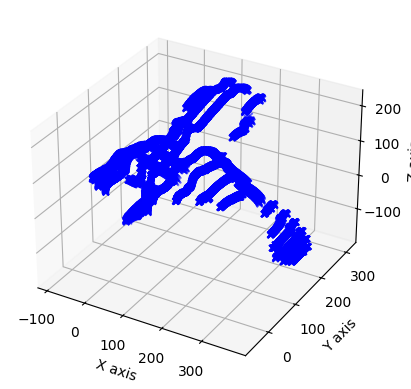

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3DPoints(point):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point[0, :], point[1, :], point[2, :], c='b', marker='x')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()

# Utilisez la fonction plot3DPoints pour afficher tous les points
plot3DPoints(point)
